In [6]:
import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from ajna_commons.utils.images import get_imagens_recortadas
from padma.gym.exemplos_base.dados import db, fs, get_cursor

# Primeiro recupera um registro...

In [7]:
TEMBBOX = {'metadata.contentType': 'image/jpeg',
          'metadata.predictions.bbox': {'$exists': True}}
cursor = get_cursor(filtro=TEMBBOX, limit=1)

In [8]:
row = next(cursor)
img_recortada = get_imagens_recortadas(db, row['_id'])[0]
grid_out = fs.get(row['_id'])
raw = grid_out.read()
img_original = Image.open(io.BytesIO(raw))

In [9]:
bbox = row['metadata']['predictions'][0]['bbox']
index = row['metadata']['predictions'][0]['index']
peso = row['metadata']['predictions'][0]['peso']
vazio = row['metadata']['predictions'][0]['vazio']

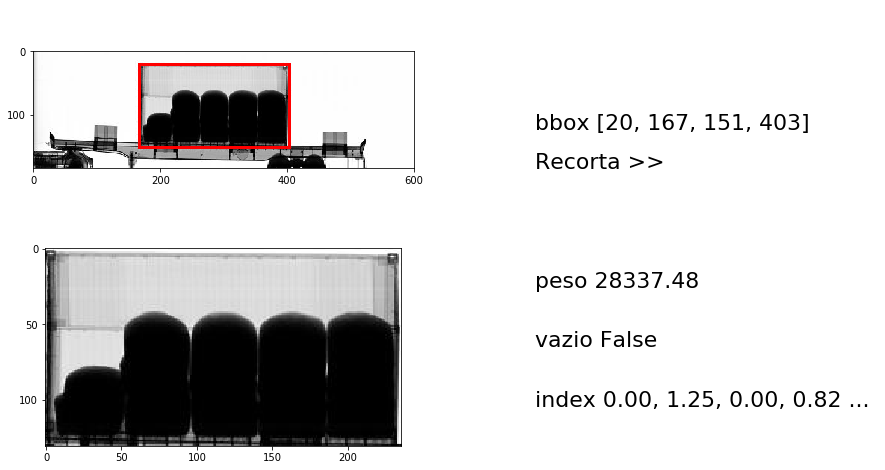

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
plt.rcParams.update({'font.size': 22})
fig.figsize=(15,8)
ax1.imshow(img_original)
rect = patches.Rectangle((bbox[1],bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
                         edgecolor='r', facecolor='none', linewidth=3)
ax1.add_patch(rect)
ax2.text(.1, .4, ' bbox %s ' % bbox)
ax2.text(.1, .2, ' Recorta >> ')
ax2.axis('off')
ax3.imshow(img_recortada)
ax4.axis('off')
ax4.text(.1, .8, ' peso {:.2f}'.format(peso))
ax4.text(.1, .5, ' vazio %s ' % vazio)
ax4.text(.1, .2, ' index %s ...' % ', '.join(['{:.2f}'.format(n) for n in index[:4]]))
plt.show()

## No exemplo acima, foi utilizado o "cache" da predição gravado no Banco de Dados
### Abaixo, demonstração de como fazer a predição "live" através do Servidor de modelos PADMA


In [20]:
import requests
from ajna_commons.flask.conf import PADMA_URL
# sys.path.insert(0, os.path.join('..', 'virasana'))
# from virasana.integracao import get_service_password

data = {}
data['image'] = raw
headers = {}
result = {'predictions': [], 'success': False}
s = requests.Session()
# username, password = get_service_password()
# r = login(username, password, s)
r = s.post(PADMA_URL + '/predict?model=ssd',
           files=data, headers=headers)
print(r.json())

{'predictions': [{'class': 2, 'bbox': [20, 167, 151, 403]}], 'success': True}


In [21]:
image_bytes = io.BytesIO()
img_recortada.save(image_bytes, 'JPEG')
image_bytes.seek(0)
data['image'] = image_bytes
r = s.post(PADMA_URL + '/predict?model=peso',
           files=data, headers=headers)
print(r.json())

{'predictions': [{'peso': 28337.480494505493}], 'success': True}


In [24]:
image_bytes.seek(0)
data['image'] = image_bytes
r = s.post(PADMA_URL + '/predict?model=vaziosvm',
           files=data, headers=headers)
print(r.json())

{'predictions': [{'vazio': False}], 'success': True}
